# Fully Dynamic k-center Clustering

## Parsing

This section has to be runned only once; its role is to parse the data and create a .hdf5 dataset with three fields: one for the timestamp, one for the latitude, one for the longitude. We will use this file in the following sections.

In [1]:
import h5py
def parse_input(path):
    dataset = h5py.File("dataset.hdf5", "w")
    timestamps = dataset.create_dataset("timestamps", (1000000,), dtype='i')
    latitudes = dataset.create_dataset("latitudes", (1000000,), dtype='f')
    longitudes = dataset.create_dataset("longitudes", (1000000,), dtype='f')
    f = open(path,'r')
    for i, line in enumerate(f):
        line = line.split()
        timestamps[i] = int(line[0])
        latitudes[i] = float(line[1])
        longitudes[i] = float(line[2])
    dataset.close()

In [2]:
parse_input('dataset/twitter_1000000.txt')

## Data visualization

Just to check that our geographical data look relevant, i.e that it "coincides" with a world map (at least on the part of the world that are conneted to Twitter!)

In [1]:
import h5py
f = h5py.File('dataset.hdf5', 'r')

In [2]:
timestamps = f['timestamps']
latitudes = f['latitudes']
longitudes = f['longitudes']
for i in range(0, 10):
    print(latitudes[i], longitudes[i])

(0.37526667, 52.263897)
(121.03524, 14.651666)
(-61.205151, -27.213259)
(101.69062, 3.0527644)
(12.3267, 45.438599)
(135.5036, 34.680218)
(139.75256, 35.654442)
(139.77625, 35.713306)
(4.0833302, 48.299999)
(103.85493, 1.300463)


In [3]:
dataset = list(zip(latitudes, longitudes))
for i in range(0, 10):
    print(dataset[i])

(0.37526667, 52.263897)
(121.03524, 14.651666)
(-61.205151, -27.213259)
(101.69062, 3.0527644)
(12.3267, 45.438599)
(135.5036, 34.680218)
(139.75256, 35.654442)
(139.77625, 35.713306)
(4.0833302, 48.299999)
(103.85493, 1.300463)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
sample_dataset = random.sample(dataset, 4000)
sample_latitudes = [sample[0] for sample in sample_dataset]
sample_longitudes = [sample[1] for sample in sample_dataset]

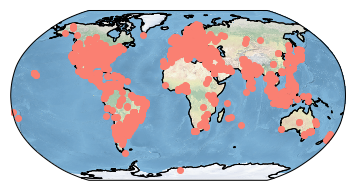

'\nplt.scatter(sample_latitudes, sample_longitudes, s=7)\nplt.xlabel("Latitude")\nplt.ylabel("Longitude")\nplt.show()'

In [9]:
import cartopy.crs as ccrs
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.stock_img()
ax.coastlines()
plt.plot(sample_latitudes, sample_longitudes, 'o', transform=ccrs.PlateCarree(), color='salmon')
plt.show()


'''
plt.scatter(sample_latitudes, sample_longitudes, s=7)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()'''

## Basic static algorithm 

### Definition of the metric

Here we define a metric that is consistent with the data we deal with : the Haversine distance, which is basically the number of kilometers between two points located with their GPS coordinates.

In [6]:
import math

def Haversine(point, neighbor):
    lat1 = point[0]
    lat2 = neighbor[0]
    lon1 = point[1]
    lon2 = neighbor[1]
    R=6371000                             
    phi_1=math.radians(lat1)
    phi_2=math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi/2.0)**2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda/2.0)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        
    return R*c/1000

In [7]:
Haversine(dataset[0], dataset[1])
Haversine(dataset[0], dataset[2])

9483.092886325172

### Computation of the Betas

In [14]:
import numpy as np

id_to_coords = {i : point for i, point in enumerate(dataset)}

def max_and_min_dists(id_to_coords, sample):
    max_dist = 0
    min_dist = np.infty
    n = len(sample)
    for i in range(0, n-1):
        point = id_to_coords[sample[i]]
        for j in range(i+1, n):
            neighbor = id_to_coords[sample[j]]
            print(point, neighbor)
            distance = Haversine(point, neighbor)
            if distance > max_dist:
                max_dist = distance
            if distance < min_dist:
                min_dist = distance
    return max_dist, min_dist

In [15]:
"""maxima, minima = [], []
for i in range(0, 10):
    print('computing on sample ', i)
    sample = random.sample(list(range(0, 1000000)), 5000)
    maximum, minimum = max_and_min_dists(id_to_coords, sample)
    maxima.append(maximum)
    minima.append(minimum)
print(max(maxima))
print(min(minima))"""

"maxima, minima = [], []\nfor i in range(0, 10):\n    print('computing on sample ', i)\n    sample = random.sample(list(range(0, 1000000)), 5000)\n    maximum, minimum = max_and_min_dists(id_to_coords, sample)\n    maxima.append(maximum)\n    minima.append(minimum)\nprint(max(maxima))\nprint(min(minima))"

In [16]:
def compute_betas(d_min, d_max, eps):
    betas = []
    i_min = math.ceil(math.log(d_min)/math.log(1+eps))
    i_max = math.floor(math.log(d_max)/math.log(1+eps))
    for i in range(i_min, i_max+1):
        betas.append((1+eps)**i)
    return betas

In [17]:
betas = compute_betas(1, 20000, 0.5)
print('minimum beta : ', betas[0])
print('maximum beta : ', betas[-1])
print('number of betas : ', len(betas))

TypeError: range() integer end argument expected, got float.

### Static clustering

In [ ]:
def build_cluster(center_id, beta, dataset_ids, cluster_id, clusters):
    center = id_to_coords[center_id]
    clusters[center_id] = (1, cluster_id)
    i = 0
    print('building new cluster...')
    while True:
        if i >= len(dataset_ids):
            break      
        point_id = dataset_ids[i]
        if point_id != center_id:
            distance = Haversine(center, id_to_coords[point_id])
            if distance <= 2*beta:
                clusters[point_id] = (0, cluster_id)
                dataset_ids.remove(point_id)
            else:
                i += 1
        else:
            dataset_ids.remove(point_id)
    print(len(dataset_ids), 'points remain to be affected')
    return dataset_ids, clusters

In [ ]:
from copy import deepcopy

def build_beta_clustering(k, beta, dataset_ids):
    clusters = {}
    d = deepcopy(dataset_ids)
    for i in range(0, k):
        if not d:
            break
        center_id = random.sample(dataset_ids, 1)[0]
        d, clusters = build_cluster(center_id, beta, d, i, clusters)
    if d:
        for point_id in d:
            clusters[point_id] = (0, -1)
    return clusters

In [ ]:
def build_whole_clustering(k, betas, dataset_ids):
    clustering = {}
    for beta in betas:
        print('computing for beta = ', beta)
        clusters = build_beta_clustering(k, beta, dataset_ids)
        clustering[beta] = clusters
    return clustering

In [ ]:
clustering = build_whole_clustering(7, [3000], random.sample(list(range(0, 1000000)), 20000))

In [ ]:
clusters = clustering[5000]
c = defaultdict(int)
for point_id, cluster in clusters.items():
    c[cluster[1]] += 1
c

In [ ]:
i = 0
counted = defaultdict(int)
col = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] 
for point_id, cluster in clusters.items():
    if i > 1000 or counted[cluster[1]] > 100:
        break
    if cluster[1] !=  -1:
        i+=1
        counted[cluster[1]] +=1
        point_coords = id_to_coords[point_id]
        plt.scatter(point_coords[0], point_coords[1],s = 10, c = col[cluster[1]])

plt.show()

In [ ]:
import matplotlib.pyplot as plt

import cartopy.crs as ccrs


def main():
    ax = plt.axes(projection=ccrs.Robinson())

    # make the map global rather than have it zoom in to
    # the extents of any plotted data
    ax.set_global()

    ax.stock_img()
    ax.coastlines()

    plt.plot(-0.08, 51.53, 'o', transform=ccrs.PlateCarree())
    plt.plot([-0.08, 132], [51.53, 43.17], transform=ccrs.PlateCarree())
    plt.plot([-0.08, 132], [51.53, 43.17], transform=ccrs.Geodetic())

    plt.show()


if __name__ == '__main__':
    main()

In [1]:
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
ax = plt.axes(projection=ccrs.Robinson())

# make the map global rather than have it zoom in to
# the extents of any plotted data
ax.set_global()

ax.stock_img()
ax.coastlines()

plt.plot(-0.08, 51.53, 'o', transform=ccrs.PlateCarree())
plt.plot([-0.08, 132], [51.53, 43.17], transform=ccrs.PlateCarree())
plt.plot([-0.08, 132], [51.53, 43.17], transform=ccrs.Geodetic())

plt.show()